## Custom pytorch example - fake dataset with increasingly complex models

### Step 1 - make a fake dataset and plot it

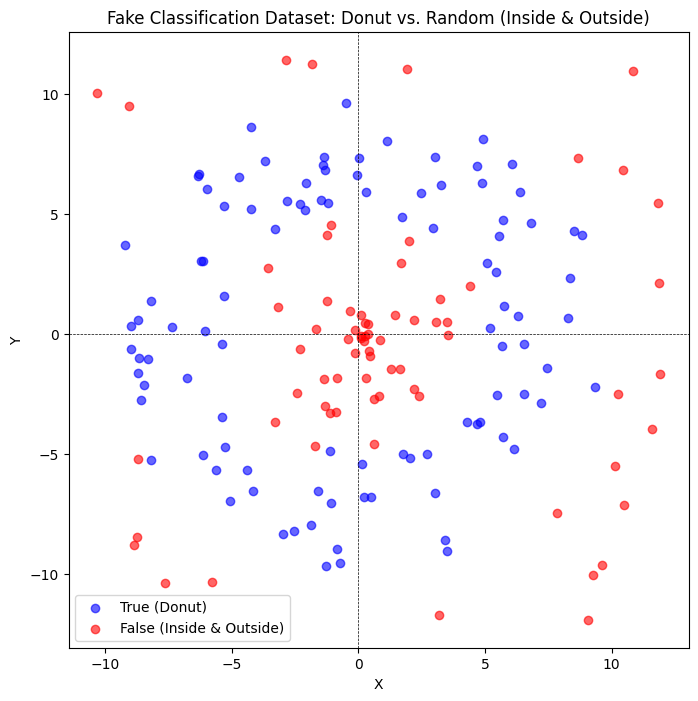

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def generate_donut_data(num_true=500, num_false=500, inner_radius=5, outer_radius=10, false_ratio_inside=0.5, seed=42):
    """Generates a fake classification dataset with a donut-shaped True class and random False points inside & outside."""
    np.random.seed(seed)

    # Generate True class (donut)
    angles = np.random.uniform(0, 2 * np.pi, num_true)
    radii = np.random.uniform(inner_radius, outer_radius, num_true)
    x_true = radii * np.cos(angles)
    y_true = radii * np.sin(angles)
    labels_true = np.ones(num_true)

    # Generate False class inside the donut hole
    num_false_inside = int(num_false * false_ratio_inside)
    angles_inside = np.random.uniform(0, 2 * np.pi, num_false_inside)
    radii_inside = np.random.uniform(0, inner_radius, num_false_inside)
    x_false_inside = radii_inside * np.cos(angles_inside)
    y_false_inside = radii_inside * np.sin(angles_inside)

    # Generate False class outside the donut
    num_false_outside = num_false - num_false_inside
    x_false_outside = np.random.uniform(-12, 12, num_false_outside)
    y_false_outside = np.random.uniform(-12, 12, num_false_outside)

    # Remove outside points that land inside the donut ring
    mask = np.sqrt(x_false_outside**2 + y_false_outside**2) > outer_radius
    x_false_outside, y_false_outside = x_false_outside[mask], y_false_outside[mask]

    # Combine False points
    x_false = np.concatenate([x_false_inside, x_false_outside])
    y_false = np.concatenate([y_false_inside, y_false_outside])
    labels_false = np.zeros(len(x_false))  # Ensure correct shape

    # Stack data into (N, 2) shape
    X = np.column_stack((np.concatenate([x_true, x_false]), np.concatenate([y_true, y_false])))
    y = np.concatenate([labels_true, labels_false])

    return X, y

def plot_donut_data(X, y):
    """Plots the generated classification dataset."""
    plt.figure(figsize=(8, 8))
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='True (Donut)', alpha=0.6)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='False (Inside & Outside)', alpha=0.6)
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
    plt.legend()
    plt.title("Fake Classification Dataset: Donut vs. Random (Inside & Outside)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

def train_test_split_donut(X, y, test_size=0.2, random_state=42):
    """Performs a train/test split on the donut dataset."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Generate data
X, y = generate_donut_data()

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split_donut(X, y)

# Plot full dataset
#plot_donut_data(X, y)

# Optional: Plot only train or test set
# plot_donut_data(X_train, y_train)
plot_donut_data(X_test, y_test)


### Make a pytorch dataloader

In [43]:
import torch
from torch.utils.data import Dataset, DataLoader

class XYDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1) # Make labels from Shape (N,) to (N, 1)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [67]:
dataset_train = XYDataset(X_train,y_train)
dataset_test = XYDataset(X_test, y_test)

batch_size = 16
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

## Making Networks

In [68]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

Using cpu device


In [152]:
from torch import nn
import torch.optim as optim

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2,16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32,8),
            nn.ReLU(),
            nn.Linear(8,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)
print(model)


NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [153]:
def train(dataloader, model, loss_fn, optimizer, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0 and verbose:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.round() == y).float().sum()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [154]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [155]:
for epoch in range(20):
    train(dataloader_train, model, loss_fn, optimizer)
    test(dataloader_test, model, loss_fn)

loss: 0.732224  [   16/  684]
Test Error: 
 Accuracy: 58.1%, Avg loss: 0.678450 

loss: 0.681583  [   16/  684]
Test Error: 
 Accuracy: 58.1%, Avg loss: 0.668529 

loss: 0.662746  [   16/  684]
Test Error: 
 Accuracy: 61.6%, Avg loss: 0.657152 

loss: 0.728735  [   16/  684]
Test Error: 
 Accuracy: 70.3%, Avg loss: 0.642300 

loss: 0.541294  [   16/  684]
Test Error: 
 Accuracy: 76.2%, Avg loss: 0.630807 

loss: 0.528792  [   16/  684]
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.611995 

loss: 0.482355  [   16/  684]
Test Error: 
 Accuracy: 82.0%, Avg loss: 0.579149 

loss: 0.453236  [   16/  684]
Test Error: 
 Accuracy: 82.0%, Avg loss: 0.556447 

loss: 0.635835  [   16/  684]
Test Error: 
 Accuracy: 82.0%, Avg loss: 0.521499 

loss: 0.544193  [   16/  684]
Test Error: 
 Accuracy: 83.7%, Avg loss: 0.461677 

loss: 0.347300  [   16/  684]
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.418568 

loss: 0.537138  [   16/  684]
Test Error: 
 Accuracy: 89.5%, Avg loss: 0.362563 

loss: 0.334917  

## Plot predicted vs actual 

In [156]:
import matplotlib.pyplot as plt

def plot_donut_comparison(X, y_true, y_pred):
    """Plots a comparison of actual vs predicted classification results."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # True labels (ground truth)
    axes[0].scatter(X[y_true == 1, 0], X[y_true == 1, 1], c='blue', label='True (Donut)', alpha=0.6)
    axes[0].scatter(X[y_true == 0, 0], X[y_true == 0, 1], c='red', label='False (Inside & Outside)', alpha=0.6)
    axes[0].set_title("Actual Labels")
    axes[0].axhline(0, color='black', linewidth=0.5, linestyle='--')
    axes[0].axvline(0, color='black', linewidth=0.5, linestyle='--')

    # Predicted labels
    axes[1].scatter(X[y_pred == 1, 0], X[y_pred == 1, 1], c='blue', label='Predicted True', alpha=0.6)
    axes[1].scatter(X[y_pred == 0, 0], X[y_pred == 0, 1], c='red', label='Predicted False', alpha=0.6)
    axes[1].set_title("Predicted Labels")
    axes[1].axhline(0, color='black', linewidth=0.5, linestyle='--')
    axes[1].axvline(0, color='black', linewidth=0.5, linestyle='--')

    # Shared settings
    for ax in axes:
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.legend()
    
    plt.tight_layout()
    plt.show()

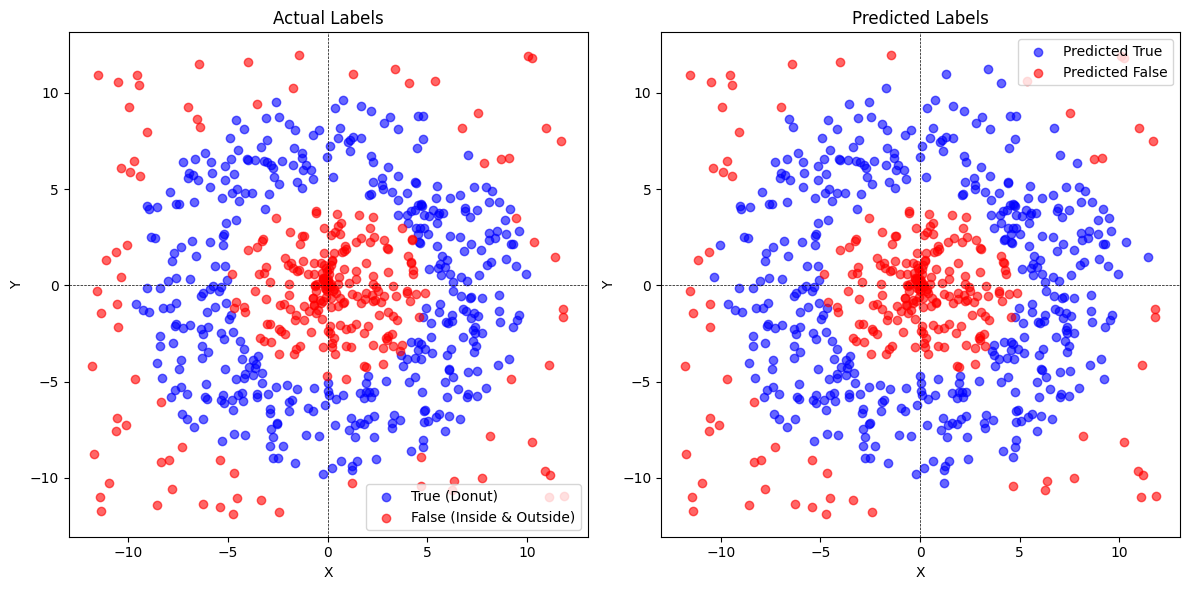

In [157]:
with torch.no_grad():
    plot_donut_comparison(X_train, y_train, model(dataloader_train.dataset.data).round().flatten())

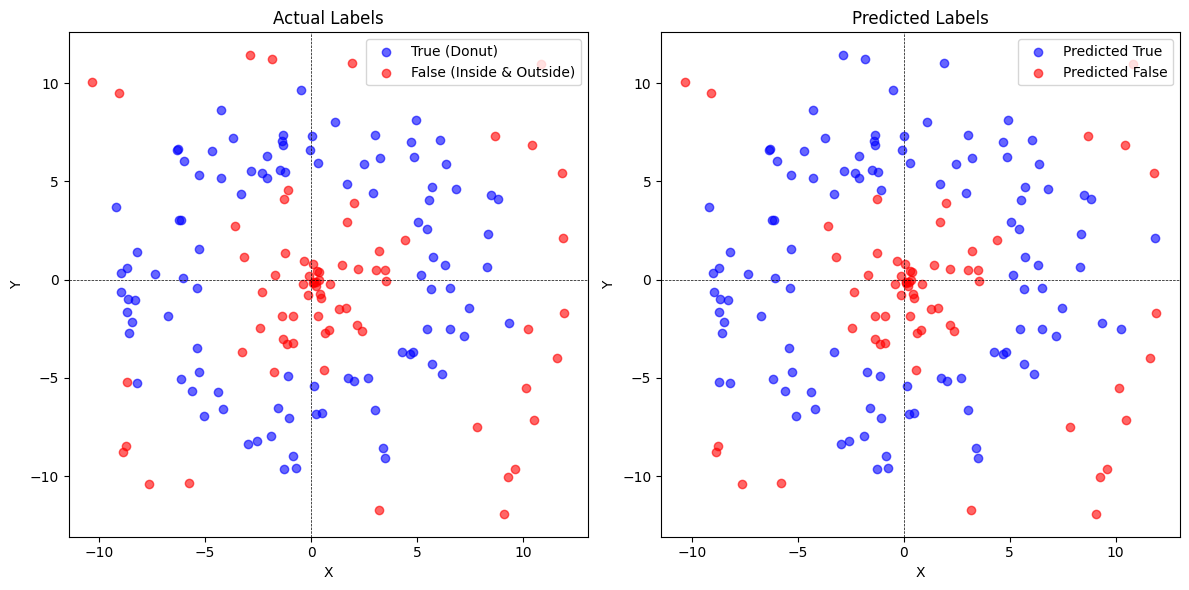

In [158]:
with torch.no_grad():
    plot_donut_comparison(X_test, y_test, model(dataloader_test.dataset.data).round().flatten())

In [ ]:
def plot_decision_boundary(X, y_true, model, resolution=100):
    """Plots the decision boundary of a trained model by sampling a grid of points."""
    # Define the grid range based on the data
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Generate a grid of points
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, resolution),
        np.linspace(y_min, y_max, resolution)
    )
    
    # Flatten the grid and predict class labels
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model(torch.from_numpy(grid_points.astype(np.float32)))
    Z = Z.reshape(xx.shape)  # Reshape to match the grid shape

    # Plot the decision boundary
    plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')  # Decision boundary
    plt.scatter(X[:, 0], X[:, 1], c='gray', edgecolors='k', alpha=0.6, s=10)  # Original data for context

    plt.title("Decision Boundary")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

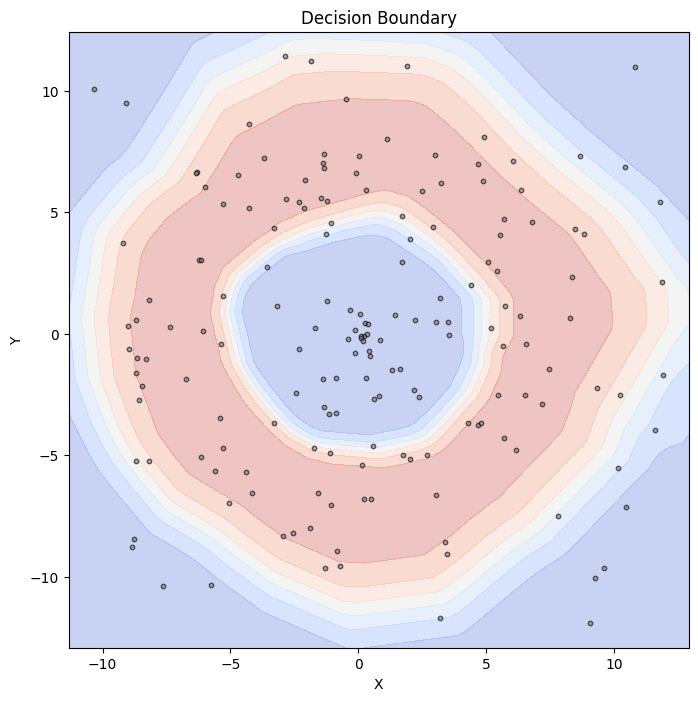

In [172]:
with torch.no_grad():
    plot_decision_boundary(X_test, model)